# Modelo de predição de preço: Dataset Airbnb / Rio de Janeiro

Neste notebook são apresentas algumas estratégias de modelagem para predição de preços em acomodações do airbnb na cidade de Rio de Janeiro.

## Importando bibliotecas

In [1]:
import pandas as pd
import json
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(rc={'figure.figsize':(7.7,7.7)}) # graph size

## Importando dataset e visualizando os dados

In [3]:
df = pd.read_csv("data_for_modeling.csv")

In [4]:
# Visão geral do dataframe

print(df.shape)
print(df.columns)

(26615, 19)
Index(['Unnamed: 0', 'neighbourhood_cleansed', 'accommodates',
       'bathrooms_text_new', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'price_new', 'neighbourhood_cleansed_new'],
      dtype='object')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26615 entries, 0 to 26614
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   26615 non-null  int64  
 1   neighbourhood_cleansed       26615 non-null  object 
 2   accommodates                 26615 non-null  int64  
 3   bathrooms_text_new           26518 non-null  float64
 4   bedrooms                     24869 non-null  float64
 5   beds                         26363 non-null  float64
 6   minimum_nights               26615 non-null  int64  
 7   maximum_nights               26615 non-null  int64  
 8   availability_365             26615 non-null  int64  
 9   number_of_reviews            26615 non-null  int64  
 10  review_scores_rating         16118 non-null  float64
 11  review_scores_accuracy       16104 non-null  float64
 12  review_scores_cleanliness    16107 non-null  float64
 13  review_scores_ch

## Modelo baseline

O primeira modelagem é feita a partir de um modelo baseline para servir de comparação com modelagens mais avançadas.

In [6]:
# Removando linhas com NaN's

df_wo_nan = df.dropna()
df_wo_nan.shape

(14834, 19)

In [7]:
df_wo_nan.describe()

,Unnamed: 0,accommodates,bathrooms_text_new,bedrooms,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price_new,neighbourhood_cleansed_new
count,14834.000000,14834.000000,14834.000000,14834.000000,14834.000000,14834.000000,1.483400e+04,14834.000000,14834.00000,14834.000000,14834.000000,14834.000000,14834.000000,14834.000000,14834.000000,14834.000000,14834.000000,14834.000000
mean,12155.016921,4.115748,1.601321,1.628152,2.550627,3.797020,6.803485e+04,210.374612,19.58312,94.617028,9.637522,9.397735,9.799987,9.758258,9.756977,9.294661,460.550694,50.449306
std,7205.545400,2.341680,0.942642,0.968905,2.073491,17.068159,8.210519e+06,137.918050,35.76731,9.747466,0.940700,1.132774,0.773541,0.832865,0.758551,1.060530,2531.937532,34.065162
min,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,1.00000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,33.000000,0.000000
25%,5548.250000,2.000000,1.000000,1.000000,1.000000,2.000000,3.600000e+01,85.000000,2.00000,93.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,149.000000,32.000000
50%,12450.500000,4.000000,1.000000,1.000000,2.000000,2.000000,1.124000e+03,207.000000,6.00000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,244.000000,32.000000
75%,17927.500000,5.000000,2.000000,2.000000,3.000000,3.000000,1.125000e+03,360.000000,19.00000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,409.000000,65.000000
max,26460.000000,16.000000,20.000000,20.000000,50.000000,1000.000000,1.000000e+09,365.000000,446.00000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,129080.000000,148.000000


In [8]:
# removendo outliers

df_wo_outliers = pd.DataFrame([])

for neighbour in df_wo_nan['neighbourhood_cleansed'].unique():
    
    max_price = df_wo_nan[df_wo_nan.neighbourhood_cleansed == neighbour]['price_new'].mean() + 2 * df_wo_nan[df_wo_nan.neighbourhood_cleansed == neighbour]['price_new'].std()
        
    df_ = df_wo_nan[df_wo_nan.neighbourhood_cleansed == neighbour][df_wo_nan.price_new <= max_price]
    
    df_wo_outliers = df_wo_outliers.append(df_)

In [9]:
df_wo_outliers.shape

(14576, 19)

In [10]:
# Normalizando dados

X = df_wo_outliers[['neighbourhood_cleansed_new', 'accommodates', 'bathrooms_text_new', 'bedrooms', 'beds']]
y = df_wo_outliers['price_new'].values

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 0)

X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

print("xtrain shape : ", X_train.shape)
print("xtest shape  : ", X_test.shape)
print("ytrain shape : ", y_train.shape)
print("ytest shape  : ", y_test.shape)

xtrain shape :  (11660, 5)
xtest shape  :  (2916, 5)
ytrain shape :  (11660,)
ytest shape  :  (2916,)


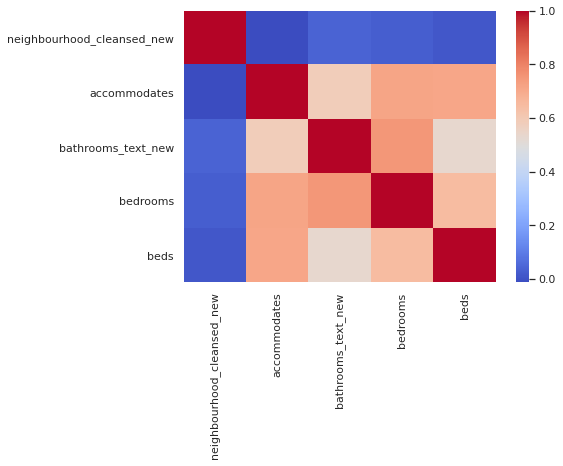

In [11]:
# Investigando multicolinearidade

corr = X.corr() 

plt.figure(figsize = (7, 5))
sns.heatmap(corr, cmap = 'coolwarm')
plt.show()

Na figura acima podemos observar que as features 'accommodates', 'bathrooms_text_new' e 'beds' apresentam correlação acima de 0.5 entre si.

In [12]:
# Ajuste do modelo de regressão multi linear para treinamento do modelo

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

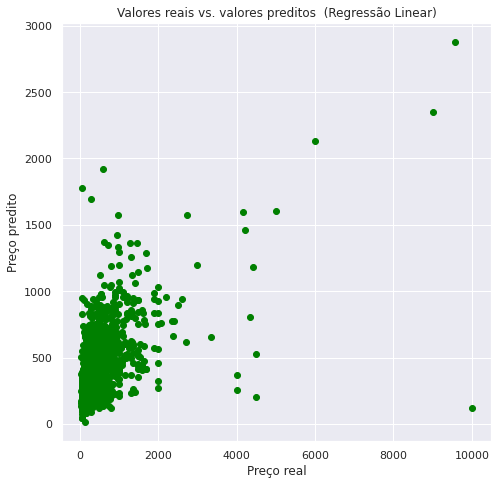

In [13]:
y_pred = regressor.predict(X_test)

plt.scatter(y_test, y_pred, c = 'green')
plt.title("Valores reais vs. valores preditos  (Regressão Linear)")
plt.xlabel('Preço real')
plt.ylabel('Preço predito')
plt.show()

Pelo gráfico acima, podemos observar de maneira geral que os preço preditos são mais próximos dos reais para valores abaixo de $1500.  
As métricas para avaliação do modelo abaixo indicam que o modelo utilizado apresenta altos valores de erro. 

In [14]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("MAE : ", mae)
print("r2 : ", r2)
print("RMSE : ", rmse)

MAE :  182.78189495108143
r2 :  0.29213334148322045
RMSE :  417.50205068598314


## Melhorando o modelo baseline: Random Forest

Com o objetivo de melhorar a predição dos preços, foi utilizado um modelo Random Forest para identificar as features que melhorem a predição.

In [15]:
# Limpeza do dataset e remoção da feature a ser predita ('price_new')

y = df_wo_outliers['price_new'].values
X = df_wo_outliers.drop(columns = {'Unnamed: 0', 'neighbourhood_cleansed', 'price_new'})

In [16]:
X.head()

,accommodates,bathrooms_text_new,bedrooms,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_cleansed_new
0,5,1.0,2.0,2.0,5,180,304,260,94.0,9.0,9.0,10.0,10.0,10.0,9.0,32
2,2,1.0,1.0,2.0,7,60,328,238,94.0,9.0,9.0,9.0,10.0,10.0,9.0,32
4,2,1.0,1.0,1.0,3,15,101,353,98.0,10.0,10.0,10.0,10.0,10.0,10.0,32
5,5,1.0,2.0,0.0,3,365,365,18,84.0,8.0,9.0,9.0,9.0,9.0,9.0,32
7,8,3.5,4.0,6.0,4,750,1,4,87.0,9.0,9.0,9.0,9.0,9.0,7.0,32


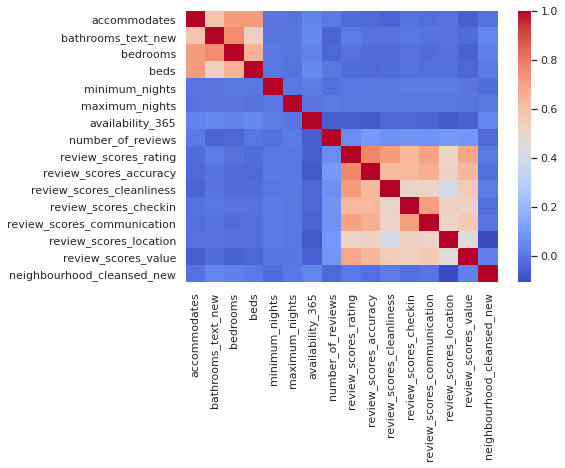

In [16]:
# investigando multicolinearidade

corr = X.corr() 

plt.figure(figsize = (7, 5))
sns.heatmap(corr, cmap = 'coolwarm')
plt.show()

### Encontrando as melhores features para predizer o preço

In [17]:
# Separando as variáveis de treinamento e de teste

sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 0)

X_train.head()

,accommodates,bathrooms_text_new,bedrooms,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_cleansed_new
11794,2,1.0,1.0,2.0,1,1125,89,76,94.0,9.0,8.0,10.0,9.0,10.0,9.0,32
14778,6,1.0,2.0,3.0,2,15,148,17,100.0,10.0,10.0,10.0,10.0,10.0,10.0,32
8516,5,1.0,1.0,3.0,1,1125,365,1,80.0,6.0,8.0,10.0,10.0,8.0,6.0,8
9905,4,1.0,1.0,1.0,3,89,0,78,98.0,10.0,10.0,10.0,10.0,10.0,9.0,109
7901,3,1.0,2.0,2.0,5,1125,363,7,97.0,10.0,10.0,10.0,10.0,10.0,10.0,32


In [18]:
# Normalizando as features

cols = X_train.columns
sc = StandardScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=cols)

In [22]:
# Treinando o modelo

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_sc, y_train)

RandomForestRegressor(random_state=42)

Text(0.5, 1.0, 'Importância das features')

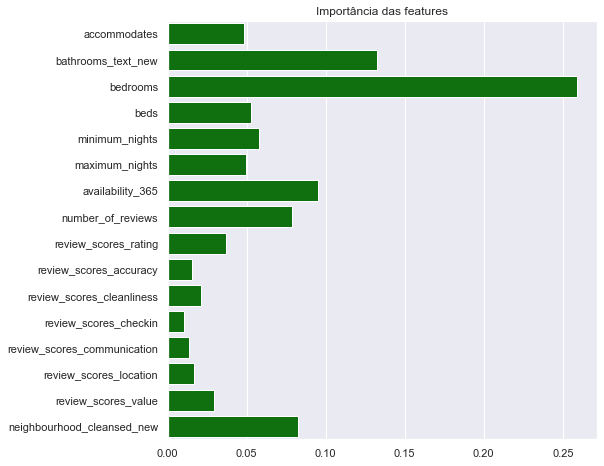

In [23]:
feature_importances = pd.Series(data=rf.feature_importances_, index=cols)
sns.barplot(x=feature_importances, y=feature_importances.index, orient='h', color='green')
plt.title('Importância das features')

Podemos observar que as 5 features que melhor descrevem o preço são às relativas ao número de quartos, número de banheiros, disponibilidade durante o ano, bairro e número de reviews. Com o uso dessas features, é criado um novo modelo para predição dos preços.

In [25]:
X = df_wo_outliers[['bathrooms_text_new', 'bedrooms', 'availability_365', 'number_of_reviews',
                    'neighbourhood_cleansed_new']]
y = df_wo_outliers['price_new'].values

sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 0)

X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

print("xtrain shape : ", X_train.shape)
print("xtest shape  : ", X_test.shape)
print("ytrain shape : ", y_train.shape)
print("ytest shape  : ", y_test.shape)

xtrain shape :  (11660, 5)
xtest shape  :  (2916, 5)
ytrain shape :  (11660,)
ytest shape  :  (2916,)


In [26]:
rf_features = RandomForestRegressor(random_state=42)
rf_features.fit(X_train, y_train)  

RandomForestRegressor(random_state=42)

In [27]:
y_pred_rf = regressor.predict(X_test)

In [28]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_rf))
print('RMSE:', sqrt(mean_squared_error(y_test, y_pred_rf)))

Mean Absolute Error: 238.07727763573226
RMSE: 488.98662768568477


Podemos observar que com a utilização dessas features, os valores das métricas subiram um pouco. Para melhorar a modelagem, é realizada uma otimização dos hiperparâmetros com um novo modelo Random Forest.

In [30]:
# Número de estimadores
estimadores = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]
# Número de features
max_features = ['auto', 'sqrt']
# Profundidade da árvore
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Seleção dos dados
bootstrap = [True, False]
# Criando a random grid
random_grid = {'n_estimators': estimadores,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [31]:
random_grid

{'n_estimators': [200, 233, 266, 300, 333, 366, 400, 433, 466, 500],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'bootstrap': [True, False]}

In [32]:
rf = RandomForestRegressor(random_state=42)

# Random Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 233, 266, 300,
                                                         333, 366, 400, 433,
                                                         466, 500]},
                   random_state=42)

In [33]:
# melhores hiperparametros

rf_random.best_params_

{'n_estimators': 500,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [34]:
best_random = rf_random.best_estimator_
best_random

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=500,
                      random_state=42)

In [35]:
y_pred_best_model = best_random.predict(X_test)

In [37]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_best_model))
print('RMSE:', sqrt(mean_squared_error(y_test, y_pred_best_model)))

Mean Absolute Error: 167.29340042012427
RMSE: 417.3658363602894


Podemos notar agora que o valor do MAE é menor que o encontrando com a primeira modelagem por regressão múltipla, enquando que o RMSE é o mesmo. Nos gráficos a seguir esse comparação pode ser visualizada melhor.

Text(0.5, 1.0, 'MAE')

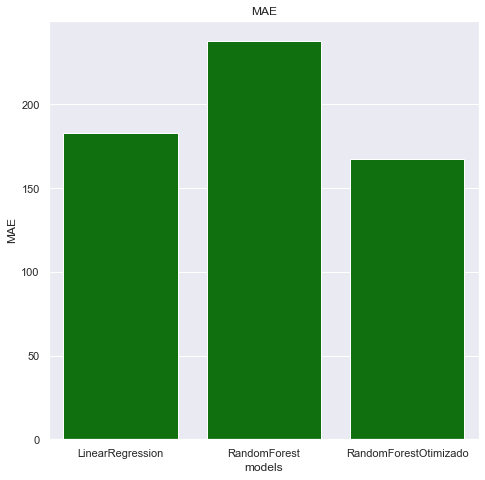

In [39]:
df_model_results = pd.DataFrame([])
df_model_results['models'] = ["LinearRegression", "RandomForest", "RandomForestOtimizado"]

df_model_results['MAE'] = [mean_absolute_error(y_test, y_pred), 
                           mean_absolute_error(y_test, y_pred_rf),
                           mean_absolute_error(y_test, y_pred_best_model)]

df_model_results['RMSE'] = [sqrt(mean_squared_error(y_test, y_pred)),
                            sqrt(mean_squared_error(y_test, y_pred_rf)),
                            sqrt(mean_squared_error(y_test, y_pred_best_model))]

sns.barplot(x='models', y='MAE', data=df_model_results, color='green')
plt.title("MAE")

Text(0.5, 1.0, 'RMSE')

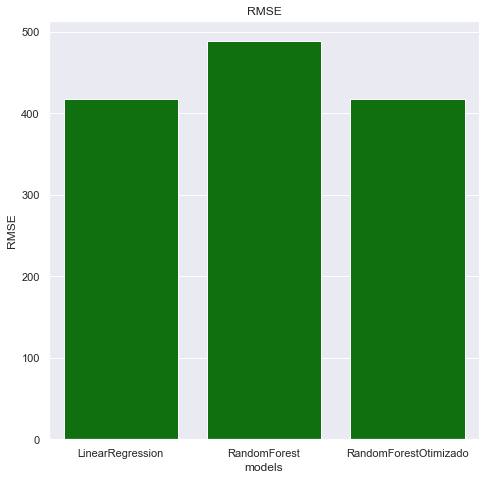

In [40]:
sns.barplot(x='models', y='RMSE', data=df_model_results, color='green')
plt.title("RMSE")

Entre as três modelagens realizadas, pode-se concluir que a última (RandomForestOtimizado) é a que melhor prediz os preços, seguida pelo modelo de regressão múltipla. Entrentando, o modelo RandomForestOtimizado é o mais custoso computacionalmente.

In [41]:
# Comparação do menor MAE com o preço médio dos imóveis

df_model_results[df_model_results.MAE == df_model_results.MAE.min()]

,models,MAE,RMSE
2,RandomForestOtimizado,167.2934,417.365836


In [42]:
df_wo_outliers['price_new'].mean()

353.166506586169

O melhor modelo obtido apresenta um erro absoluto de ~47% o preço médio dos imóveis. 
Esse erro é alto e não indico que o modelo da forma que está seja usado em produção.
Esse resultado precisa ser melhorado e outras técnicas podem ser estudadas. Abaixo discutirei algumas técnicas adicionais que podem ser usadas para diminuir o erro do modelo.

* Separar o dataset em Zonas Sul / Norte / Oeste e Centro: pela análise exploratória ficou evidente que nos bairros localizados em zonas mais nobres e próximas de pontos turísticos o preço das acomodações, em geral, são mais elevados.  

* Levar em consideração a feature amenities: Esta feature contém itens na acomodação, como ar condicionado, presença de elevadores e etc, que podem influenciar na preço da acomodação.  

* Tratamento de dados faltantes: Preencher dados faltantes a partir de estratégias como obtenção de médias ou prever esses dados a partir de outras features.   



Lazypredict é uma biblioteca que testa os principais modelos do sklearn sem otimização de hiperparametros. É interessante para entendermos quais tipos de modelos performam melhor com os nossos dados. 



In [19]:
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
import numpy as np

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train_sc, X_test_sc, y_train, y_test)

print(models)

100%|██████████| 42/42 [03:16<00:00,  4.68s/it]

                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
PoissonRegressor                             0.39       0.39   387.19   
MLPRegressor                                 0.33       0.33   406.05   
ExtraTreesRegressor                          0.32       0.32   408.92   
HistGradientBoostingRegressor                0.32       0.32   408.95   
GradientBoostingRegressor                    0.32       0.32   409.11   
LGBMRegressor                                0.31       0.31   412.13   
LassoLarsIC                                  0.30       0.30   414.85   
Lasso                                        0.30       0.30   414.86   
LassoCV                                      0.30       0.30   415.03   
TransformedTargetRegressor                   0.30       0.30   415.09   
Lars                                         0.30       0.30   415.09   
LinearRegression                             0.30  

Podemos observar que vários modelos apresentam valores de RMSE menores que os encontrados com as modelagens realizadas anteriormente, indicando serem bons candidatos para futuras predições. É importante ressaltar que não foi feita uma otimização dos hiperparâmetros (Lazypredict não faz essa tarefa), indicando que esses resultados ainda podem ser melhorados.

Após o teste do Lazypredict, é interessante rodar também a biblioteca auto-sklearn. 
Auto-sklearn é uma biblioteca de auto-ml que testa diferentes formas de pré-processamento e otimização de hiperparametros. Por falta de tempo não adicionarei a parte do auto-ml nesse case. É usual que os testes com auto-ML levem alguns dias, por causa dos inúmeros testes de hiperparâmetros e pré-processamentos que precisarão ser testados.